In [1]:
using MHDFlows
using PyCall
using CUDA,Statistics
using LinearAlgebra: mul!, ldiv!
using LazCh5
using HDF5
glob = pyimport("glob2")

┌ Info: Precompiling MHDFlows [top-level]
└ @ Base loading.jl:1278
[ Info: FourierFlows will use 4 threads
┌ Info: FourierFlows will use 4 threads
└ @ FourierFlows /home/doraho/.julia/packages/FourierFlows/DtzuG/src/FourierFlows.jl:123


PyObject <module 'glob2' from '/usr/local/lib/python3.6/dist-packages/glob2/__init__.py'>

In [2]:
function ChoFroceScheme2!(N_, sol, t, clock, vars, params, grid)
  str = string
  T   = eltype(vars.nonlinh1)
  f_ih = zeros(T,size(vars.nonlinh1));

  Φ1T,Φ2T,AT = vars.Φ1,vars.Φ2,vars.A;
  fox,foy,foz = params.fo[1,:],params.fo[2,:],params.fo[3,:];
  s1,s2 = params.s1,params.s2;  
  dt  = clock.dt;  
  Random_iterator!(Φ1T,Φ2T,AT);  
  v = -0;
  Offset = div(size(vars.ux)[1],2);  
  # Added for Large Scale Forcing
  k_conponment = length(Φ1T);

    
  #Create A,Φ2 to CPU if GPU is enable
  A  = Array{T}(AT);  
  Φ1 = Array{T}(Φ1T); 
  Φ2 = Array{T}(Φ2T);
  m,l = Array{T}(grid.m[:]),Array{T}(grid.l[:]);
  #println("N,",sum(N_))
  #L1 = A[1]/√(2);  
  #S1 = [0,1/√(2),1/√(2)];
  for (u_ind,i) ∈ zip([params.ux_ind,params.uy_ind,params.uz_ind],[1,2,3])
      @. f_ih*=0;  
      for k_i = 1:k_conponment
        k_fx = fox[k_i]+1;
        k_fy = findall(m.==foy[k_i])[1];
        k_fz = findall(l.==foz[k_i])[1];
        kf2 = k_fx^2+k_fy^2+k_fz^2; 
        f_ih[k_fx,k_fy,k_fz]  = A[1]*exp(v*kf2*dt)*exp(im/2*(Φ1[k_i]+Φ2[k_i]))*
                    (s1[i,k_i]*cos((Φ2[k_i]-Φ1[k_i])/2)+s2[i,k_i]*sin((Φ2[k_i]-Φ1[k_i])/2));
      end
      #k_fy = findall(m.==0)[1];
      #k_fz = findall(l.==0)[1];  
      #f_ih[2,k_fy,k_fz] =  L1*S1[i,1];
      #f_ih[3,k_fy,k_fz] = -L1*S1[i,1];
      @. vars.nonlinh1*=0;
      copyto!(vars.nonlinh1, f_ih);   
      ldiv!(vars.nonlin1, grid.rfftplan, deepcopy(vars.nonlinh1));  
      mul!(vars.nonlinh1, grid.rfftplan, vars.nonlin1) 

      N_[:,:,:,u_ind] .+= vars.nonlinh1;
      #println("N,",sum(N_[:,:,:,u_ind]))   
  end
  #N.=N; 
end
function Random_iterator!(Φ1,Φ2,A)
    #random generator ∈ [-1,1]
    rand1CPU(n::Int;T=Float32) = 2.0 .*(rand(T,n).-0.5);
    rand1CUDA(n::Int;T=Float32) = 2.0 .*(CUDA.rand(T,n).-0.5);
    
    rand1 = Φ1 isa CuArray ? rand1CUDA : rand1CPU;
    T = eltype(Φ2)
    k_conponment = length(Φ1);
    Φ_changefraction   = convert(T,0.02);
    A_changefraction   = convert(T,0.01);

    # For each time step, slowly changing the amplitude or phase by 1 or 2%
    Φ1 .= Φ1.*( 1 .+ 2*π .*rand1(k_conponment;T=T).*Φ_changefraction);
    Φ2 .= Φ2.*( 1 .+ 2*π .*rand1(k_conponment;T=T).*Φ_changefraction);
    #just 1 conponment for now
    A .= A.*(1.0 .+ rand1(1;T=T)*A_changefraction);
end    

Random_iterator! (generic function with 1 method)

In [3]:
function ProblemGeneratorTG!(prob;L0=2π,N=length(prob.grid.x))

  # Output Setting  
  xx,yy,zz = fill(0.0,N,N,N),fill(0.0,N,N,N),fill(0.0,N,N,N);
  
  l = π/L0;    
  for k ∈ 1:N, j ∈ 1:N, i ∈ 1:N
    xx[i,j,k] = l*prob.grid.x[i];
    yy[i,j,k] = l*prob.grid.y[j];
    zz[i,j,k] = l*prob.grid.z[k];
  end
    
  pfactor = 4/3*sqrt(2/3);
  R  = 0;
    

  ux = @. cos(yy);
  uy = @. 0*cos(yy);
  uz = @. 0*cos(yy);

  bx = @. sqrt(1e-3)*ux;
  by = @. sqrt(1e-3)*uy;
  bz = @. sqrt(1e-3)*uz;       
    
  copyto!(prob.vars.ux, ux);
  copyto!(prob.vars.uy, uy);
  copyto!(prob.vars.uz, uz);
  copyto!(prob.vars.bx, bx);
  copyto!(prob.vars.by, by);
  copyto!(prob.vars.bz, bz);

  #Update V + B Fourier Conponment
  uxh = prob.sol[:, :, :, prob.params.ux_ind];
  uyh = prob.sol[:, :, :, prob.params.uy_ind];
  uzh = prob.sol[:, :, :, prob.params.uz_ind];
    
  bxh = prob.sol[:, :, :, prob.params.bx_ind];
  byh = prob.sol[:, :, :, prob.params.by_ind];
  bzh = prob.sol[:, :, :, prob.params.bz_ind];

  mul!(uxh, prob.grid.rfftplan, prob.vars.ux);   
  mul!(uyh, prob.grid.rfftplan, prob.vars.uy);
  mul!(uzh, prob.grid.rfftplan, prob.vars.uz);
  mul!(bxh, prob.grid.rfftplan, prob.vars.bx);
  mul!(byh, prob.grid.rfftplan, prob.vars.by);
  mul!(bzh, prob.grid.rfftplan, prob.vars.bz);
    
  prob.sol[:, :, :, prob.params.ux_ind] .= uxh;
  prob.sol[:, :, :, prob.params.uy_ind] .= uyh;
  prob.sol[:, :, :, prob.params.uz_ind] .= uzh;
  prob.sol[:, :, :, prob.params.bx_ind] .= bxh;
  prob.sol[:, :, :, prob.params.by_ind] .= byh;
  prob.sol[:, :, :, prob.params.bz_ind] .= bzh;
    
  MHDupdatevars!(prob);
      
  return nothing
end

ProblemGeneratorTG! (generic function with 1 method)

In [4]:
function integration_with_save(prob;dump_dt=1,loop_number=100,deg=[],file_number=1,A0 = Float32(5e6))
    t_next = prob.clock.t + dump_dt;
    @CUDA.time for i = 1:loop_number
        stepforward!(prob,deg,1)
        MHDupdatevars!(prob);
        t = GPUprob.clock.t;
        if t>= t_next
           GPUprob.vars.A .= A0;
           KE_,ME_ = ProbDiagnostic(GPUprob);
           isnan(KE_) ? error("detected NaN! Quite the simulation right now.") : nothing;
           savefile(prob,file_number)
           t_next += dump_dt;
           file_number +=1;
            
        end
        
    end
end


function savefile(prob,file_number)
    space_0 = ""
    for i = 1:4-length(string(file_number));space_0*="0";end
    fw = h5open("/mnt/c/data/Aniso3/Spectral_Test_t_"*space_0*string(file_number)*".h5","w")
    write(fw, "i_velocity",  Array(prob.vars.ux));
    write(fw, "j_velocity",  Array(prob.vars.uy));
    write(fw, "k_velocity",  Array(prob.vars.uz));
    write(fw, "i_mag_field", Array(prob.vars.bx));
    write(fw, "j_mag_field", Array(prob.vars.by));
    write(fw, "k_mag_field", Array(prob.vars.bz));
    write(fw, "time", prob.clock.t);
    close(fw) 
end

function ProbDiagnostic(prob)
    dV = (2π/GPUprob.grid.nl)^3;
    vx,vy,vz = prob.vars.ux,prob.vars.uy,prob.vars.uz;
    KE =  string(round(sum(vx.^2+vy.^2 + vz.^2)*dV,sigdigits=2));
    bx,by,bz = prob.vars.bx,prob.vars.by,prob.vars.bz;
    ME =  string(round(sum(bx.^2+by.^2 + bz.^2)*dV,sigdigits=2));
    tt =  string(round(prob.clock.t,sigdigits=2));
    for i = 1:8-length(string(tt));tt= " "*tt;end
    for i = 1:8-length(string(ME));ME= " "*ME;end
    for i = 1:8-length(string(KE));KE= " "*KE;end
    println("t = $tt, KE = $KE, ME= $ME")
    return parse(Float32,KE),parse(Float32,ME)
end

ProbDiagnostic (generic function with 1 method)

In [26]:
#parameters
N = 128;
Lx = 2π;
ν,η = 7.4e-4,7.4e-4;
dt = 1/100;
#A0 = Float32(1e7);
A0 = Float32(2e6); #Aniso2
#A0 = Float32(9e4); Aniso3
# Testing the problem 
GPUprob  = ChoProblem(GPU();nx = N,Lx = Lx,
                             ν = ν,
                            nν = 1,
                             η = η, 
               # Timestepper and equation options
                            dt = dt,
                       stepper = "RK4",
                         calcF = ChoFroceScheme2!,
                            A0 = A0,
                            kf = 25,
               # Float type and dealiasing
                             T = Float32)

Problem
  ├─────────── grid: grid (on GPU)
  ├───── parameters: params
  ├────── variables: vars
  ├─── state vector: sol
  ├─────── equation: eqn
  ├────────── clock: clock
  └──── timestepper: RK4TimeStepper

In [27]:
ProblemGeneratorTG!(GPUprob)

In [28]:
CUDA.memory_status()
CUDA.reclaim()
GC.gc(true)
CUDA.memory_status()

Effective GPU memory usage: 73.18% (7.318 GiB/10.000 GiB)
CUDA allocator usage: 6.133 GiB
binned usage: 6.133 GiB (2.898 GiB allocated, 3.234 GiB cached)
Effective GPU memory usage: 40.83% (4.083 GiB/10.000 GiB)
CUDA allocator usage: 2.898 GiB
binned usage: 2.898 GiB (2.594 GiB allocated, 312.000 MiB cached)


In [29]:
using LazCh5
#function for monitoring the energy
function KEfoo(prob)
    vx,vy,vz = prob.vars.ux,prob.vars.uy,prob.vars.uz;
    return sum(vx.^2+vy.^2 + vz.^2)
end

function MEfoo(prob)
    bx,by,bz = prob.vars.bx,prob.vars.by,prob.vars.bz;
    return sum(bx.^2+by.^2 + bz.^2)
end

KE = Diagnostic(KEfoo, GPUprob);
ME = Diagnostic(MEfoo, GPUprob);
deg = [KE,ME];

In [30]:
# 1 loop = 1.5s 
dump_dt = 1
file_number = round(Int,GPUprob.clock.t/dump_dt+1)
integration_with_save(GPUprob;dump_dt=dump_dt,loop_number=10000,deg,file_number=file_number,A0 = A0)

t =      1.0, KE =    270.0, ME=      5.4
t =      2.0, KE =    230.0, ME=     38.0
t =      3.0, KE =    260.0, ME=     59.0
t =      4.0, KE =    330.0, ME=     92.0
t =      5.0, KE =    250.0, ME=     61.0
t =      6.0, KE =    240.0, ME=     53.0
t =      7.0, KE =    210.0, ME=     45.0
t =      8.0, KE =    220.0, ME=     49.0
t =      9.0, KE =    220.0, ME=     47.0
t =     10.0, KE =    220.0, ME=     48.0
t =     11.0, KE =    230.0, ME=     52.0
t =     12.0, KE =    200.0, ME=     39.0
t =     13.0, KE =    180.0, ME=     30.0
t =     14.0, KE =    190.0, ME=     29.0
t =     15.0, KE =    190.0, ME=     29.0
t =     16.0, KE =    170.0, ME=     23.0
t =     17.0, KE =    180.0, ME=     22.0
t =     18.0, KE =    170.0, ME=     21.0
t =     19.0, KE =    170.0, ME=     18.0
t =     20.0, KE =    160.0, ME=     14.0
t =     21.0, KE =    160.0, ME=     14.0
t =     22.0, KE =    150.0, ME=     13.0
t =     23.0, KE =    150.0, ME=     12.0
t =     24.0, KE =    160.0, ME=  

┌ Warning: You are using Matplotlib 3.3.4, which is no longer
│ officialy supported by the Plots community. To ensure smooth Plots.jl
│ integration update your Matplotlib library to a version >= 3.4.0
│ 
│ If you have used Conda.jl to install PyPlot (default installation),
│ upgrade your matplotlib via Conda.jl and rebuild the PyPlot.
│ 
│ If you are not sure, here are the default instructions:
│ 
│ In Julia REPL:
│ ```
│ import Pkg;
│ Pkg.add("Conda")
│ import Conda
│ Conda.update()
│ Pkg.build("PyPlot")
│ ```
│ 
└ @ Plots /home/doraho/.julia/packages/Plots/AJMX6/src/backends/pyplot.jl:29


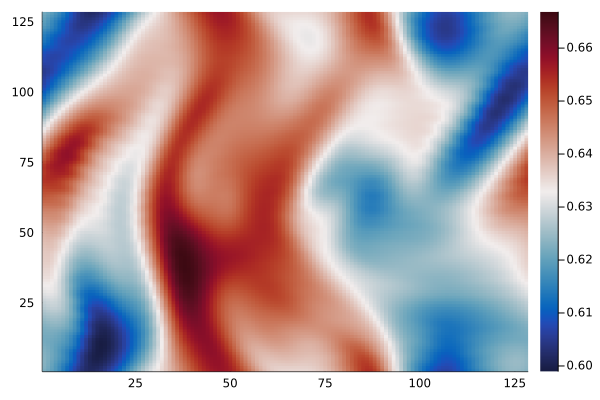

In [11]:
using Plots
p1 = heatmap( Array(GPUprob.vars.ux)[:,:,10],vmin=-0.5,vmax=0.5,c = :balance);
l = @layout Plots.grid(1, 1)
p = Plots.plot(p1, layout = l)

In [22]:
ff = sort(glob.glob("/mnt/c/data/Aniso"));

In [23]:
anim = @animate for fs ∈ ff
    f = h5open(fs,"r")
    ib = read( f , "i_mag_field", ) ;
    close(f)
    B1 = ib[:,:,1];
    p[1][1][:z] = B1;
end

Animation("/tmp/jl_brlyMm", String[])

In [24]:
mp4(anim, "twodturb.mp4", fps=30)

LoadError: [91mArgumentError: Cannot build empty animations[39m

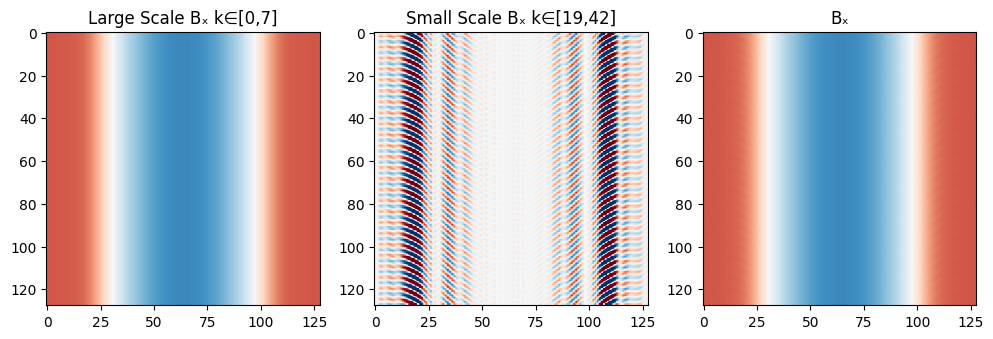

PyObject <matplotlib.image.AxesImage object at 0x7f00e1f82e80>

In [26]:
ib,jb,kb = Array(GPUprob.vars.bx),Array(GPUprob.vars.by),Array(GPUprob.vars.bz)
B1L,B2L,B3L = Energydecomposition(ib,jb,kb;kf=[0,7]);
B1S,B2S,B3S = Energydecomposition(ib,jb,kb;kf=[19,42]);
using PyPlot
figure(figsize=(12,4))
subplot(131)
title("Large Scale Bₓ k∈[0,7]")
plotM = B1L[:,:,1];
imshow(plotM,cmap="RdBu",vmin=mean(plotM)-2*std(plotM),vmax=mean(plotM)+2*std(plotM))
subplot(132)
title("Small Scale Bₓ k∈[19,42]")
plotM = B1S[:,:,1];
imshow(plotM,cmap="RdBu",vmin=mean(plotM)-2*std(plotM),vmax=mean(plotM)+2*std(plotM))
subplot(133)
title("Bₓ")
plotM = ib[:,:,1];
imshow(plotM,cmap="RdBu",vmin=mean(plotM)-2*std(plotM),vmax=mean(plotM)+2*std(plotM))


In [8]:
function Energydecomposition(B1,B2,B3;kf=[1,5],Lx = 2π)
    
    k1,k2 = minimum(kf),maximum(kf);
    nx,ny,nz = size(B1);
    T    = Float32;
    grid = ThreeDGrid(nx, Lx, T = T);
    
    B1h = zeros(ComplexF32,(div(nx,2)+1,ny,nz));
    B2h = zeros(ComplexF32,(div(nx,2)+1,ny,nz));
    B3h = zeros(ComplexF32,(div(nx,2)+1,ny,nz));
    Bxhf = copy(B1h); 
    Byhf = copy(B2h);
    Bzhf = copy(B3h);
    mul!(B1h, grid.rfftplan, B1); 
    mul!(B2h, grid.rfftplan, B2); 
    mul!(B3h, grid.rfftplan, B3);
    
    
    for i in 1:div(nz,2)+1, j in 1:ny, k in 1:nx
       x,y,z = grid.kr[i],grid.l[j],grid.m[k];
       rr    = sqrt(x^2+y^2+z^2); 
       if (( rr >=  k1) && (rr <= k2))
           Bxhf[i,j,k] = B1h[i,j,k];
           Byhf[i,j,k] = B2h[i,j,k];
           Bzhf[i,j,k] = B3h[i,j,k];
       end
    end
    cB1,cB2,cB3 = zeros(T,size(B1)),zeros(T,size(B1)),zeros(T,size(B1));
    ldiv!(cB1, grid.rfftplan,Bxhf);  
    ldiv!(cB2, grid.rfftplan,Byhf);
    ldiv!(cB3, grid.rfftplan,Bzhf);
    return cB1,cB2,cB3;
end


Energydecomposition (generic function with 1 method)